Solution for Assignment 5 of the course “Introduction to Machine Learning” at the University of Leoben.
Author: Fotios Lygerakis
Semester: SS 2022/2023

Implement the Gaussian Processes algorithm as a class in Python. The class should be able to perform the following tasks:
1. Fit the model to a given training data set (X, y) with X ∈ Rn×d and y ∈ Rn.
2. Predict the output for a given test data set X∗ ∈ Rm×d.
3. Compute the log marginal likelihood of the training data set.
4. Compute the gradients of the log marginal likelihood with respect to the hyperparameters.
5. Compute the predictive mean and variance for a given test data set X∗ ∈ Rm×d.
6. Compute the gradients of the predictive mean and variance with respect to the hyperparameters.
7. Use the gradients of the log marginal likelihood and the gradients of the predictive mean and variance to optimize the hyperparameters of the kernel function.

Implement the following kernel functions:
1. linear kernel: k(x, x′) = xT x′
2. polynomial kernel: k(x, x′) = (xT x′ + 1)d
3. Periodic kernel: k(x, x′) = exp(−2sin2(π||x − x′||/p)/σ2)
4. Gaussian kernel: k(x, x′) = exp(−||x − x′||2/2σ2)

Test your implementation on 1D, 2D and 3D data sets. Compare the results with the results of the scikit-learn implementation of Gaussian Processes.

Import the necessary libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist


Datasets

In [6]:
step_size = 0.5
#1D data set
X_1D = np.arange(-5, 5, step_size).reshape(-1, 1)
y_1D = np.sin(X_1D) + np.random.normal(0, 0.1, size=(len(X_1D), 1))
X_1D_star = np.arange(-5, 5, step_size).reshape(-1, 1)

#2D data set
X_2D_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D = np.hstack((X_2D_1, X_2D_2))
y_2D = np.sin(X_2D_1) + np.exp(X_2D_2) + np.random.normal(0, 0.1, size=(len(X_2D), 1))
X_2D_star_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D_star_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_2D_star = np.hstack((X_2D_star_1, X_2D_star_2))

#3D data set
X_3D_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_3 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D = np.hstack((X_3D_1, X_3D_2, X_3D_3))
y_3D = (
    np.sin(X_3D_1)
    + np.cos(X_3D_2)
    + X_3D_3 ** 2
    + np.random.normal(0, 0.1, size=(len(X_3D), 1))
)
X_3D_star_1 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_star_2 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_star_3 = np.arange(-5, 5, step_size).reshape(-1, 1)
X_3D_star = np.hstack((X_3D_star_1, X_3D_star_2, X_3D_star_3))


Implement the Gaussian Processes algorithm as a class in Python

In [7]:
class GaussianProcess:
    def __init__(self, kernel, sigma_n=1e-8):
        self.kernel = kernel
        self.sigma_n = sigma_n
        self.X = None
        self.y = None
        self.K = None
        self.K_inv = None
        self.alpha = None # coefficients alpha of the Gaussian process for

    def fit(self, X, y):
        self.X = X
        self.y = y
        # Compute the kernel matrix. Add a small value to the diagonal for numerical stability.
        self.K = self.kernel(self.X, self.X) + self.sigma_n * np.eye(len(self.X))
        # Compute the inverse of the kernel matrix.
        self.K_inv = np.linalg.inv(self.K)
        # Compute the coefficients alpha.
        self.alpha = np.dot(self.K_inv, self.y)

    def predict(self, X_star):
        # Compute the kernel matrix between the training data and the test data.
        K_star = self.kernel(self.X, X_star)
        # Compute the predictive mean.
        y_star = np.dot(K_star.T, self.alpha)
        # Compute the predictive variance.
        v = np.dot(self.K_inv, K_star)
        var = self.kernel(X_star, X_star) - np.dot(K_star.T, v)
        return y_star, var

    def log_marginal_likelihood(self):
        # Compute the log marginal likelihood.
        return (
            -0.5 * np.dot(self.y.T, self.alpha)
            - 0.5 * np.linalg.slogdet(self.K)[1]
            - 0.5 * len(self.X) * np.log(2 * np.pi)
        )

    def gradient(self):
        # Compute the gradient of the log marginal likelihood with respect to the kernel hyperparameters.
        # Compute the gradient of the kernel matrix with respect to the kernel hyperparameters.
        K_grad = self.kernel.gradient(self.X)
        # Compute the gradient of the log marginal likelihood.
        return (
            0.5
            * np.einsum("ijk,ij->k", K_grad, np.dot(self.K_inv, np.dot(self.y, self.y.T)))
            - 0.5 * np.einsum("ij,ijk->k", self.K_inv, K_grad)
        )

    def plot(self, X_star, y_star, var):
        plt.figure(figsize=(10, 10))
        plt.plot(self.X, self.y, "r.", markersize=10, label="Observations")
        plt.plot(X_star, y_star, "b-", label="Prediction")
        plt.fill_between(
            X_star[:, 0],
            y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
            y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),
            alpha=0.2,
            color="k",
            label="95% confidence interval",
        )
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.title(
            f"{self.kernel.__class__.__name__} \n Log-Marginal-Likelihood: {self.log_marginal_likelihood()[0][0]:.3e}"
        )
        plt.legend(loc="upper left")
        plt.show()

In [8]:
#Implement the linear kernel function
class LinearKernel:
    def __init__(self, theta=1.0):
        self.theta = theta
        self.bounds = ((1e-5, 1e5),)
        self.num_params = 1

    def __call__(self, X1, X2):
        return self.theta * np.dot(X1, X2.T)

    def set_params(self, params):
        self.theta = params[0]



In [9]:
#Implement the polynomial kernel function
class PolynomialKernel:
    def __init__(self, theta=1.0, d=3):
        self.theta = theta
        self.d = d
        self.bounds = ((1e-5, 1e5), (1, 10))
        self.num_params = 2

    def __call__(self, X1, X2):
        return (self.theta * np.dot(X1, X2.T) + 1) ** self.d

    def set_params(self, params):
        self.theta = params[0]
        self.d = params[1]

    def gradient(self, X):
        return np.array(
            [
                self.d * self.theta * np.dot(X, X.T) ** (self.d - 1),
                self.theta * np.dot(X, X.T) ** self.d * np.log(np.dot(X, X.T)),
            ]
        )

In [10]:
#Implement the periodic kernel function
class PeriodicKernel:
    def __init__(self, theta=1.0):
        self.theta = theta
        self.bounds = ((1e-5, 1e5),)
        self.num_params = 1

    def __call__(self, X1, X2):
        return np.exp(-2 * np.sin(np.pi * cdist(X1, X2) / self.theta) ** 2)

    def set_params(self, params):
        self.theta = params[0]


In [11]:
#Implement the radial basis function kernel function
class RBFKernel:
    def __init__(self, theta=1.0):
        self.theta = theta
        self.bounds = ((1e-5, 1e5),)
        self.num_params = 1

    def __call__(self, X1, X2):
        return np.exp(-self.theta * cdist(X1, X2) ** 2)

    def set_params(self, params):
        self.theta = params[0]


### Test your implementation. Compare the results with the results of the scikit-learn implementation of Gaussian Processes.

Initialize the kernels

In [12]:
#Linear kernel
kernel_linear = LinearKernel(theta=1.0)
#Polynomial kernel
kernel_poly = PolynomialKernel(theta=1.0, d=2)
#Periodic kernel
kernel_periodic = PeriodicKernel(theta=1.0)
#Radial basis function kernel
kernel_rbf = RBFKernel(theta=1.0)

### Initialize the Gaussian Process with the kernels and fit the data

In [13]:
gp_linear = GaussianProcess(kernel=kernel_linear, sigma_n=1e-8)
gp_poly = GaussianProcess(kernel=kernel_poly, sigma_n=1e-8)
gp_periodic = GaussianProcess(kernel=kernel_periodic, sigma_n=1e-8)
gp_rbf = GaussianProcess(kernel=kernel_rbf, sigma_n=1e-8)

### Fit the 1D data

In [14]:
gp_linear.fit(X_1D, y_1D)
gp_poly.fit(X_1D, y_1D)
gp_periodic.fit(X_1D, y_1D)
gp_rbf.fit(X_1D, y_1D)

### Predict the values of the test data

In [15]:
y_star_linear, var_linear = gp_linear.predict(X_1D_star)
y_star_poly, var_poly = gp_poly.predict(X_1D_star)
y_star_periodic, var_periodic = gp_periodic.predict(X_1D_star)
y_star_rbf, var_rbf = gp_rbf.predict(X_1D_star)

### Plot the results

/tmp/ipykernel_12816/3712199621.py:45: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/tmp/ipykernel_12816/3712199621.py:46: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),


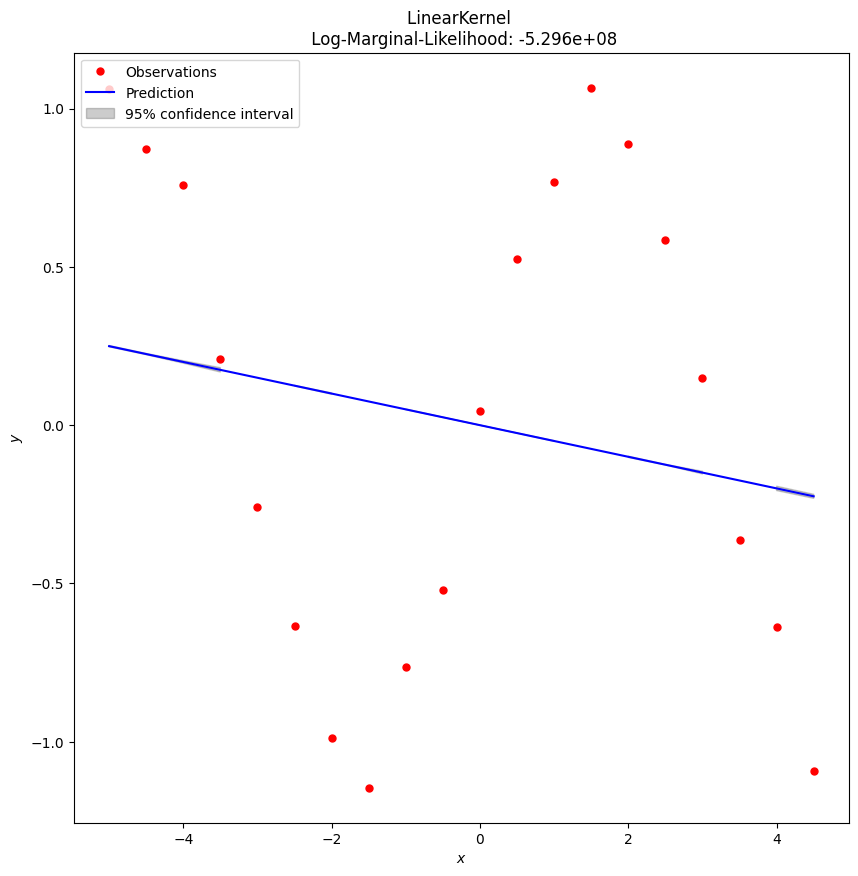

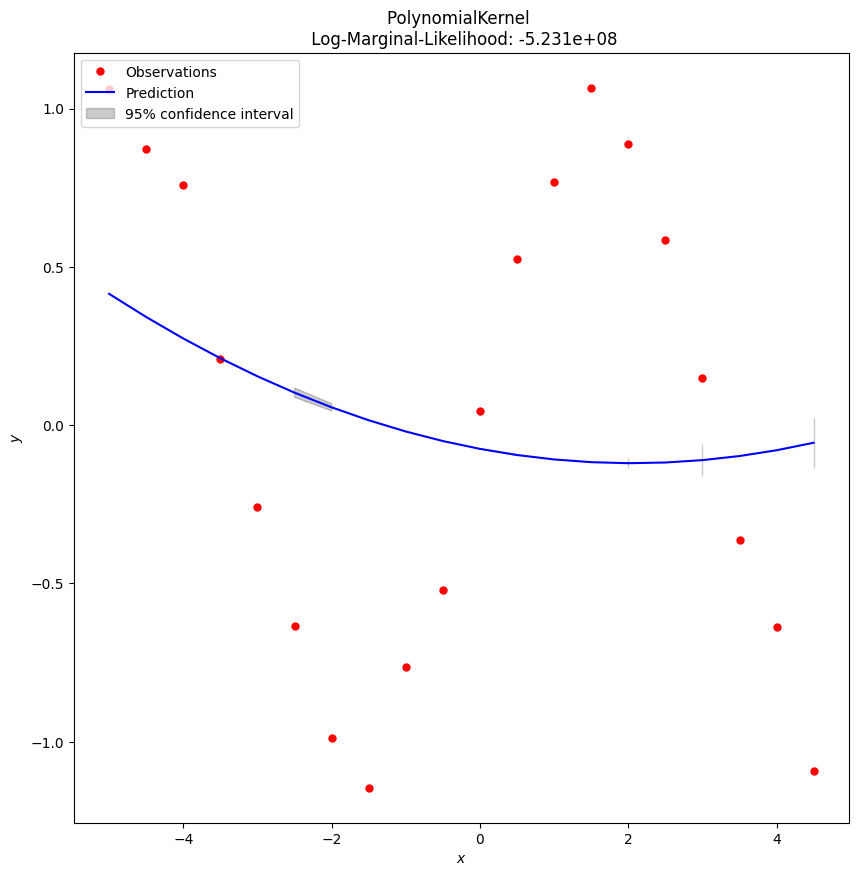

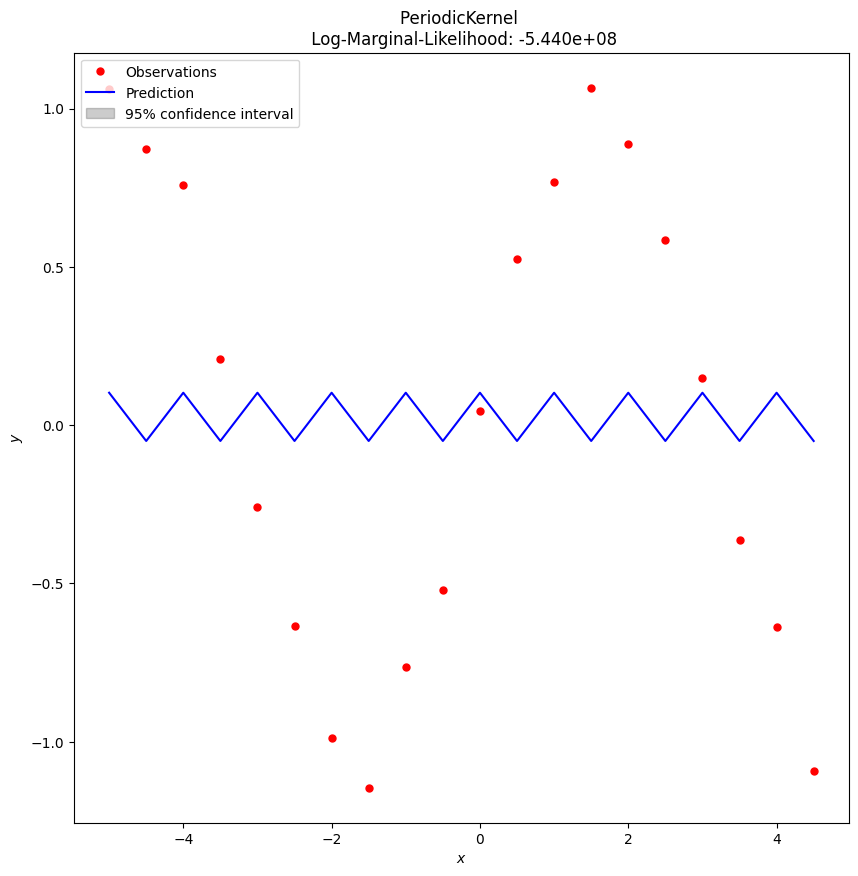

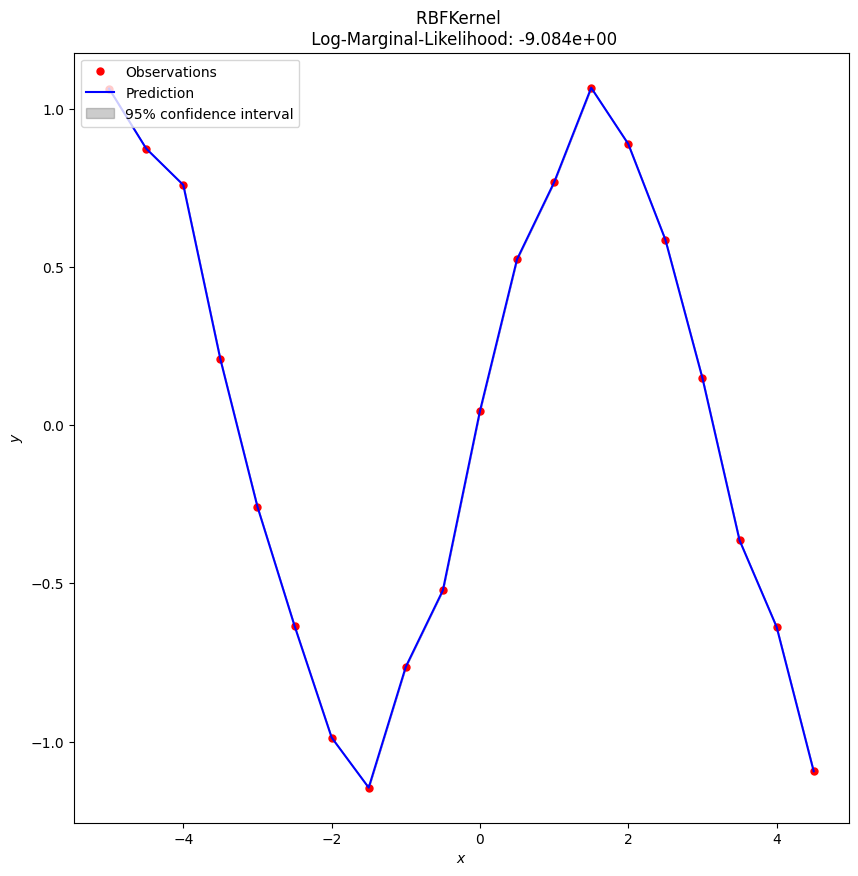

In [16]:
gp_linear.plot(X_1D_star, y_star_linear, var_linear)
gp_poly.plot(X_1D_star, y_star_poly, var_poly)
gp_periodic.plot(X_1D_star, y_star_periodic, var_periodic)
gp_rbf.plot(X_1D_star, y_star_rbf, var_rbf)

### Fit the 2D data

In [17]:
gp_linear.fit(X_2D, y_2D)
gp_poly.fit(X_2D, y_2D)
gp_periodic.fit(X_2D, y_2D)
gp_rbf.fit(X_2D, y_2D)

### Predict the values of the test data

In [18]:
y_star_linear, var_linear = gp_linear.predict(X_2D_star)
y_star_poly, var_poly = gp_poly.predict(X_2D_star)
y_star_periodic, var_periodic = gp_periodic.predict(X_2D_star)
y_star_rbf, var_rbf = gp_rbf.predict(X_2D_star)

### Plot the results

/tmp/ipykernel_12816/3712199621.py:45: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/tmp/ipykernel_12816/3712199621.py:46: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),


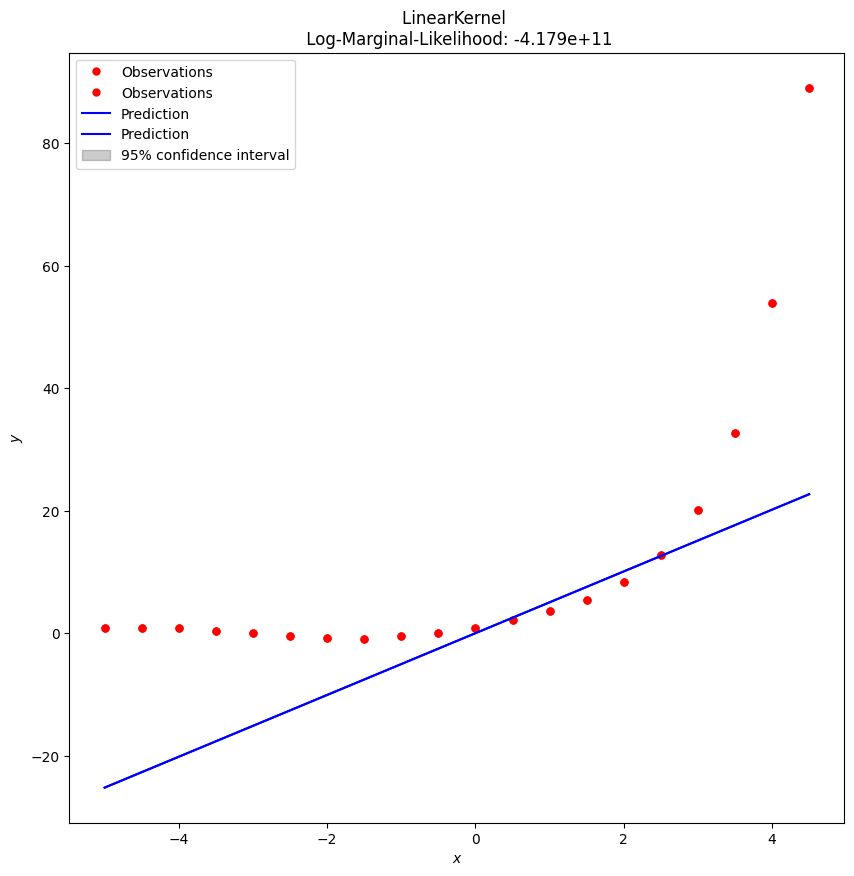

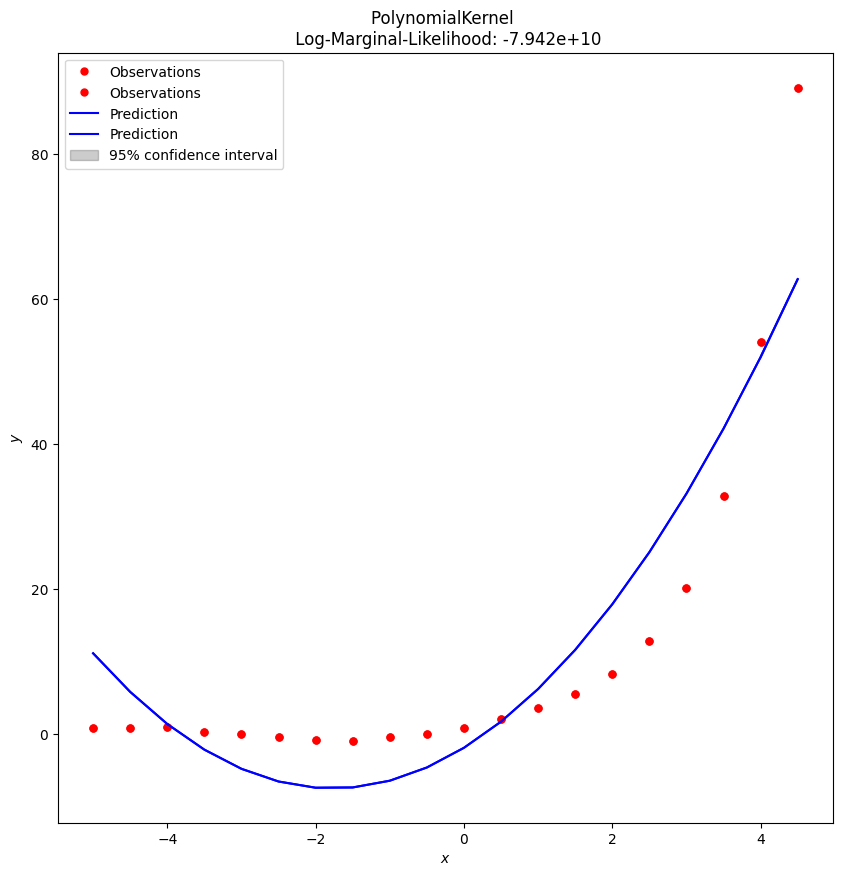

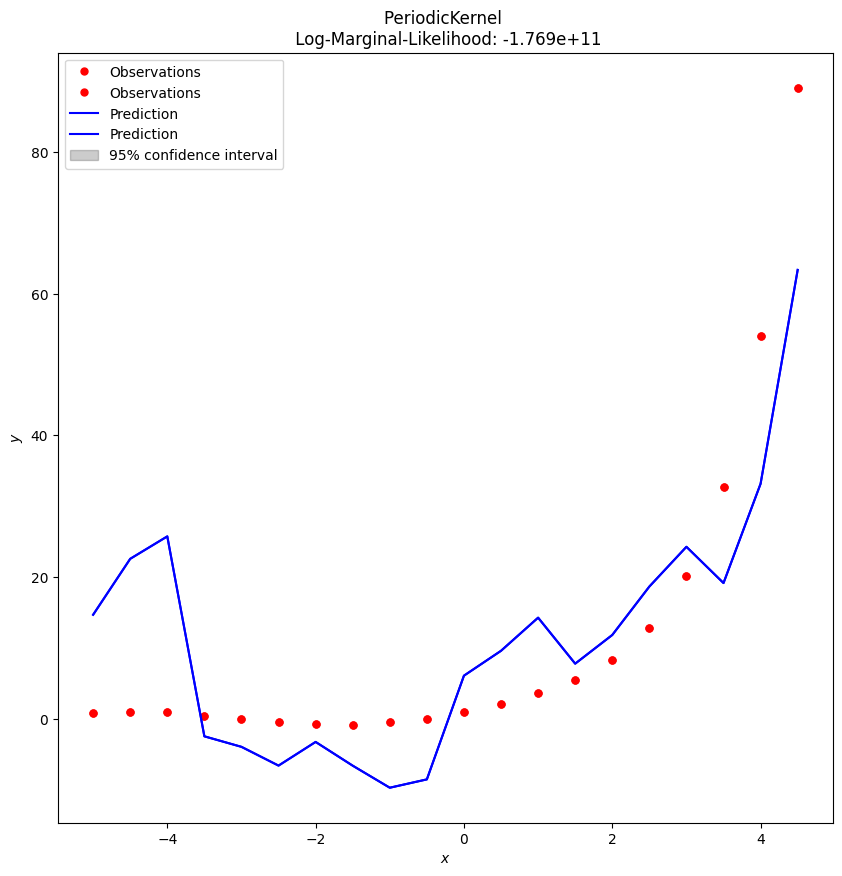

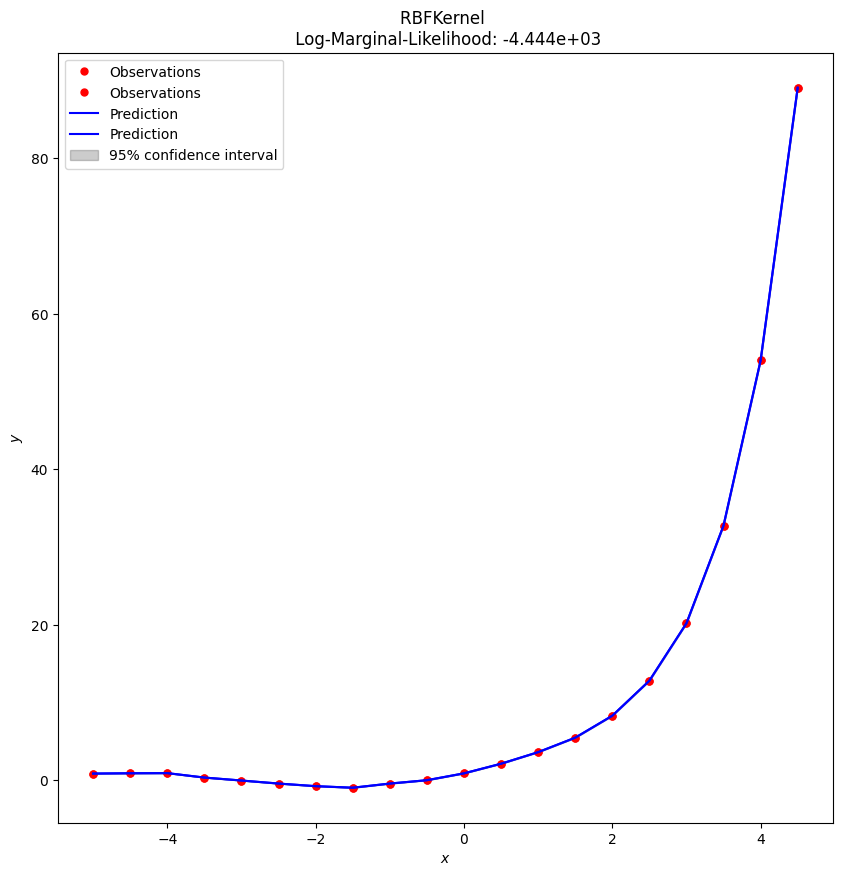

In [19]:
gp_linear.plot(X_2D_star, y_star_linear, var_linear)
gp_poly.plot(X_2D_star, y_star_poly, var_poly)
gp_periodic.plot(X_2D_star, y_star_periodic, var_periodic)
gp_rbf.plot(X_2D_star, y_star_rbf, var_rbf)

### Fit the 3D data

In [20]:
gp_linear.fit(X_3D, y_3D)
gp_poly.fit(X_3D, y_3D)
gp_periodic.fit(X_3D, y_3D)
gp_rbf.fit(X_3D, y_3D)

### Predict the values of the test data

In [21]:
y_star_linear, var_linear = gp_linear.predict(X_3D_star)
y_star_poly, var_poly = gp_poly.predict(X_3D_star)
y_star_periodic, var_periodic = gp_periodic.predict(X_3D_star)
y_star_rbf, var_rbf = gp_rbf.predict(X_3D_star)

### Plot the results

/tmp/ipykernel_12816/3712199621.py:45: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] - 1.96 * np.sqrt(np.diag(var)),
/tmp/ipykernel_12816/3712199621.py:46: RuntimeWarning: invalid value encountered in sqrt
  y_star[:, 0] + 1.96 * np.sqrt(np.diag(var)),


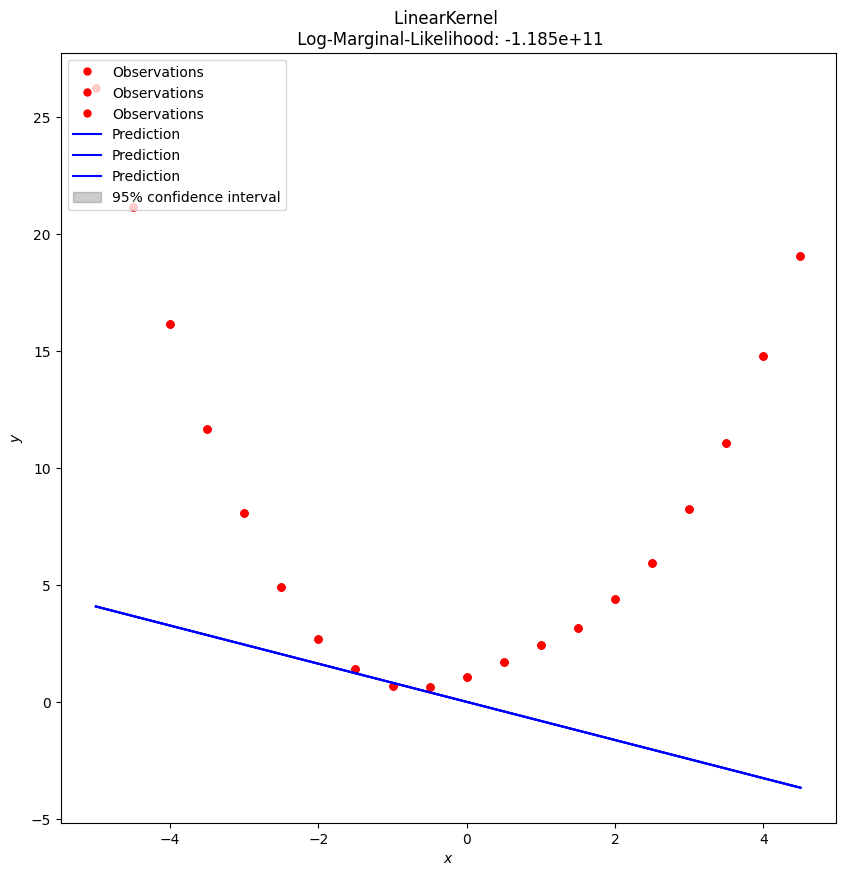

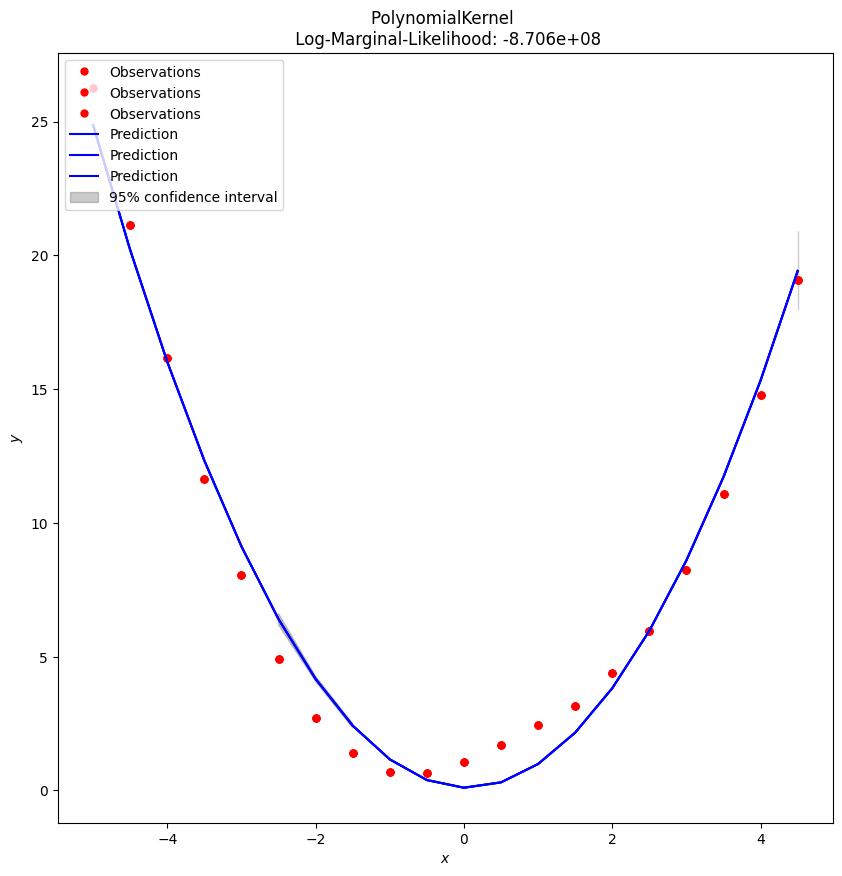

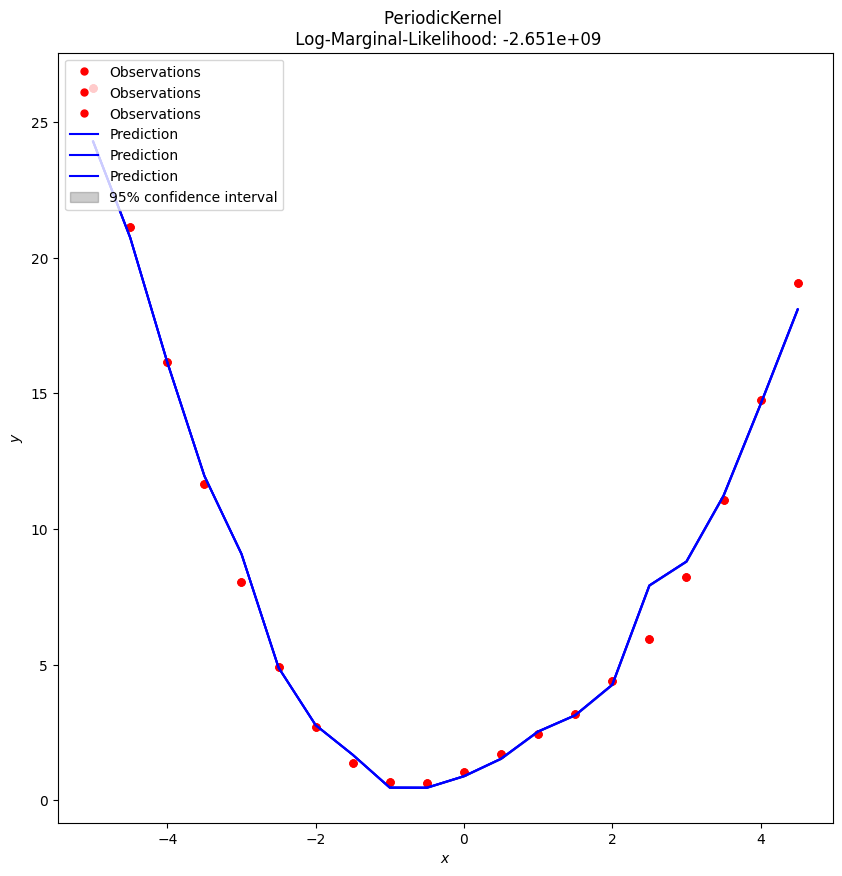

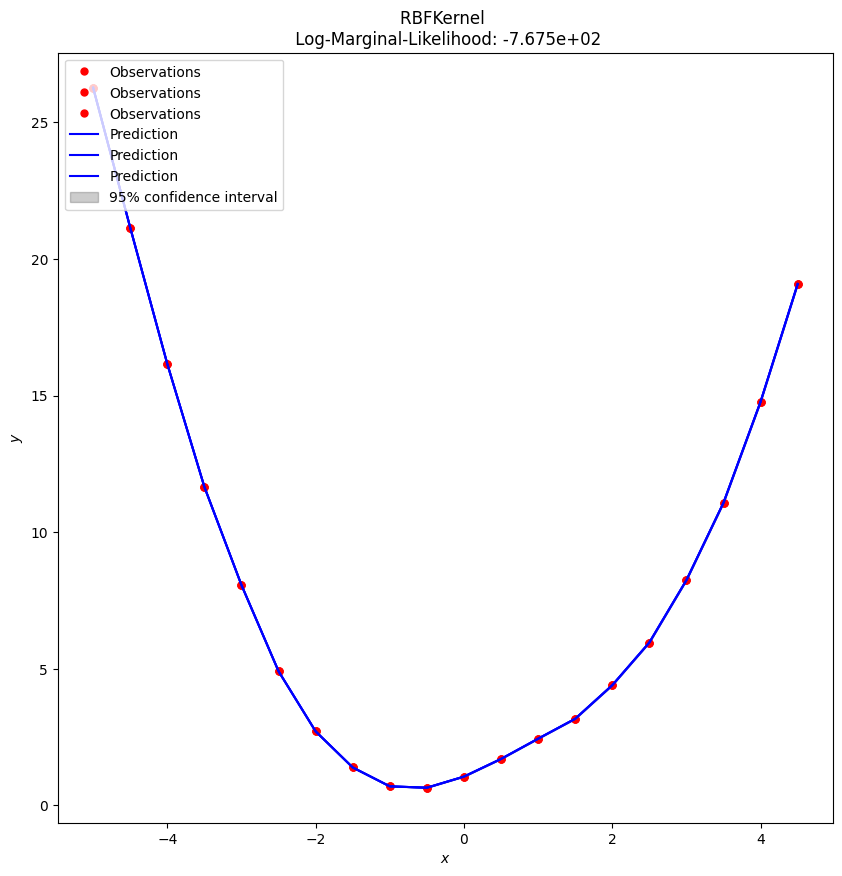

In [22]:
gp_linear.plot(X_3D_star, y_star_linear, var_linear)
gp_poly.plot(X_3D_star, y_star_poly, var_poly)
gp_periodic.plot(X_3D_star, y_star_periodic, var_periodic)
gp_rbf.plot(X_3D_star, y_star_rbf, var_rbf)

Compare the results with the results of the scikit-learn implementation of Gaussian Processes

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


In [24]:
# Fit the sklearn model
gp = GaussianProcessRegressor(kernel=RBF(length_scale=1.0), alpha=1e-8)
gp.fit(X_1D, y_1D)

# Fit the custom model
gp_rbf.fit(X_1D, y_1D)

/home/liger/PycharmProjects/ML_course/venv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


### Predict the values of the test data

In [25]:
# Predict the mean and variance of the test data using the scikit-learn implementation
y_star, var = gp.predict(X_1D_star, return_std=True)
# Predict the mean and variance of the test data using the custom implementation
y_star_rbf, var_rbf = gp_rbf.predict(X_1D_star)

Plot the results comparing with the results of the scikit-learn with the ccustom implementation of Gaussian Processes using the RBF kernel

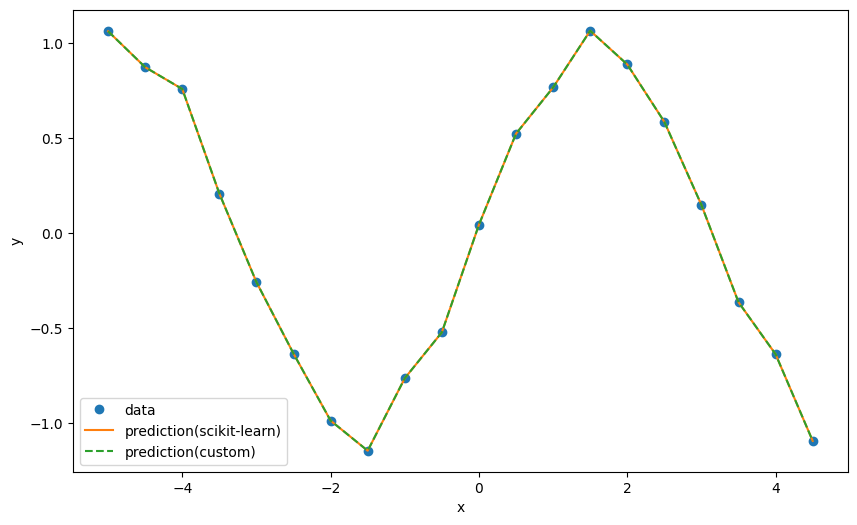

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(X_1D, y_1D, "o", label="data")

plt.plot(X_1D_star, y_star, "-", label="prediction(scikit-learn)")
plt.plot(X_1D_star, y_star_rbf, "--", label="prediction(custom)")

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")



# Bonus: Use the Gaussian Process to fit any dataset of your choice